In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 
  
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from xgboost import XGBClassifier 
from sklearn import metrics 
  
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("MAJORR/FB.csv") 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,23-05-2018,182.500000,186.910004,182.179993,186.899994,186.899994,16628100
1,24-05-2018,185.880005,186.800003,185.029999,185.929993,185.929993,12354700
2,25-05-2018,186.020004,186.330002,184.449997,184.919998,184.919998,10965100
3,29-05-2018,184.339996,186.809998,183.710007,185.740005,185.740005,16398900
4,30-05-2018,186.539993,188.000000,185.250000,187.669998,187.669998,13736900


In [11]:
df.shape

(252, 7)

In [7]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,168.205873,170.341667,166.336389,168.384365,168.384365,2.265027e+07
std,20.697326,20.445685,20.934147,20.848751,20.848751,1.419471e+07
min,123.099998,129.740005,123.019997,124.059998,124.059998,7.297400e+06
25%,151.445003,153.850003,148.960007,151.272503,151.272503,1.545050e+07
50%,167.255005,169.170006,165.040001,167.064995,167.064995,1.966275e+07
75%,183.709999,185.924995,181.782494,184.062500,184.062500,2.533358e+07
max,215.720001,218.619995,214.270004,217.500000,217.500000,1.698037e+08


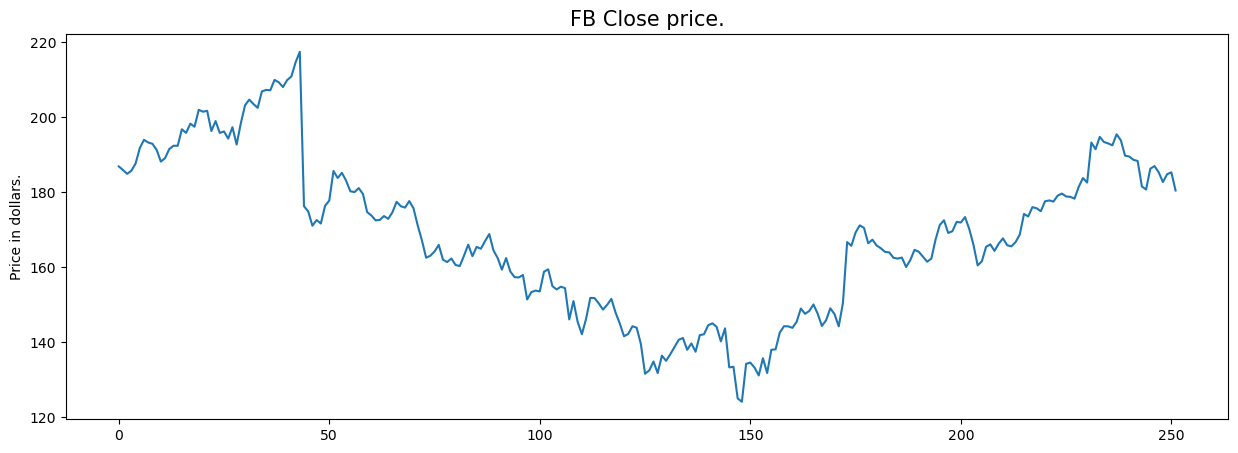

In [19]:
#EDA

plt.figure(figsize=(15,5)) 
plt.plot(df['Close']) 
plt.title('FB Close price.', fontsize=15) 
plt.ylabel('Price in dollars.') 
plt.show()

In [10]:
df[df['Close'] == df['Adj Close']].shape

(252, 7)

In [12]:
df = df.drop(['Adj Close'], axis=1)

In [18]:
df.isnull().sum()
#null value check

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

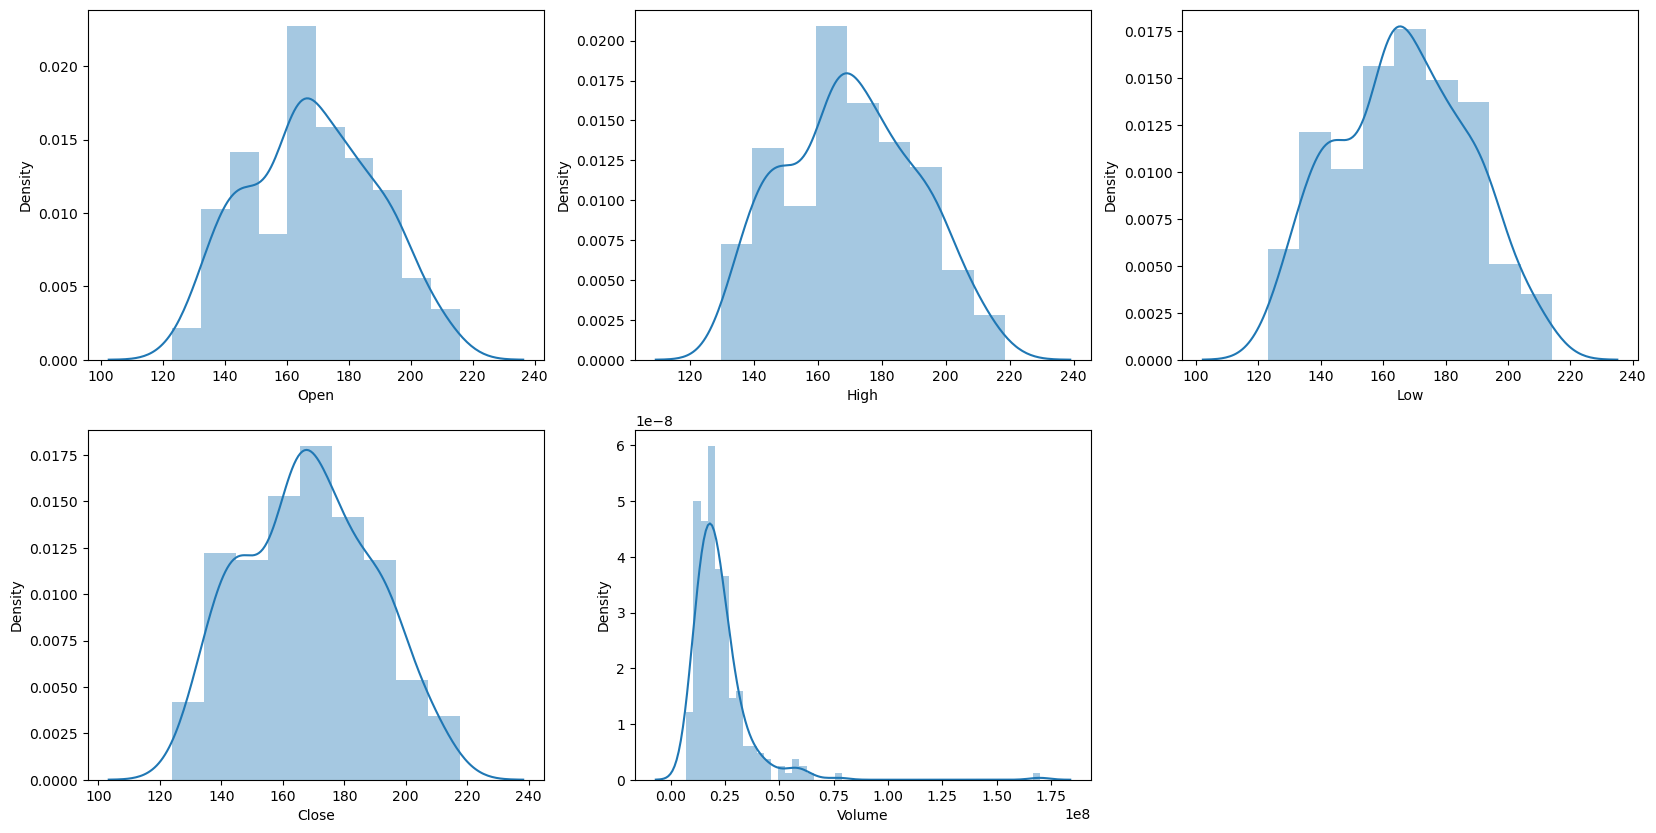

In [17]:
features = ['Open', 'High', 'Low', 'Close', 'Volume'] 
  
plt.subplots(figsize=(20,10)) 
  
for i, col in enumerate(features): 
  plt.subplot(2,3,i+1) 
  sb.distplot(df[col]) 
plt.show()
#Volume data is left-skewed.

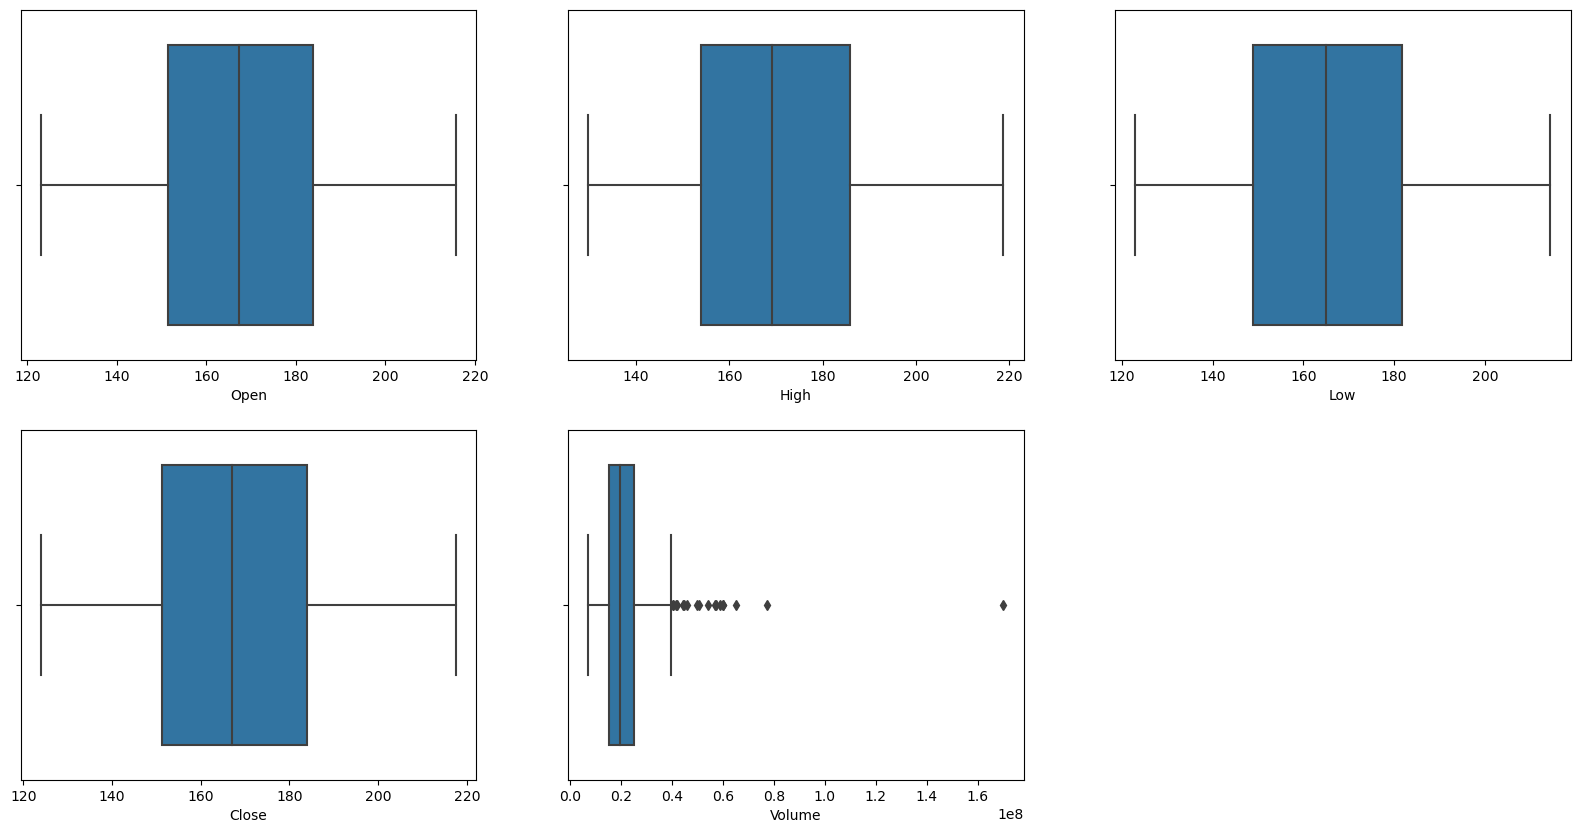

In [16]:
plt.subplots(figsize=(20,10)) 
for i, col in enumerate(features): 
  plt.subplot(2,3,i+1) 
  sb.boxplot(df[col]) 
plt.show()
#only volume data contains outliers in it but the data in the rest of the columns are free from any outlier.

In [22]:
#Feature Engineering

splitted = df['Date'].str.split('-', expand=True) 
  
df['day'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int') 
df['year'] = splitted[2].astype('int') 
  
df.head()

,Date,Open,High,Low,Close,Volume,day,month,year
0,23-05-2018,182.500000,186.910004,182.179993,186.899994,16628100,23,5,2018
1,24-05-2018,185.880005,186.800003,185.029999,185.929993,12354700,24,5,2018
2,25-05-2018,186.020004,186.330002,184.449997,184.919998,10965100,25,5,2018
3,29-05-2018,184.339996,186.809998,183.710007,185.740005,16398900,29,5,2018
4,30-05-2018,186.539993,188.000000,185.250000,187.669998,13736900,30,5,2018


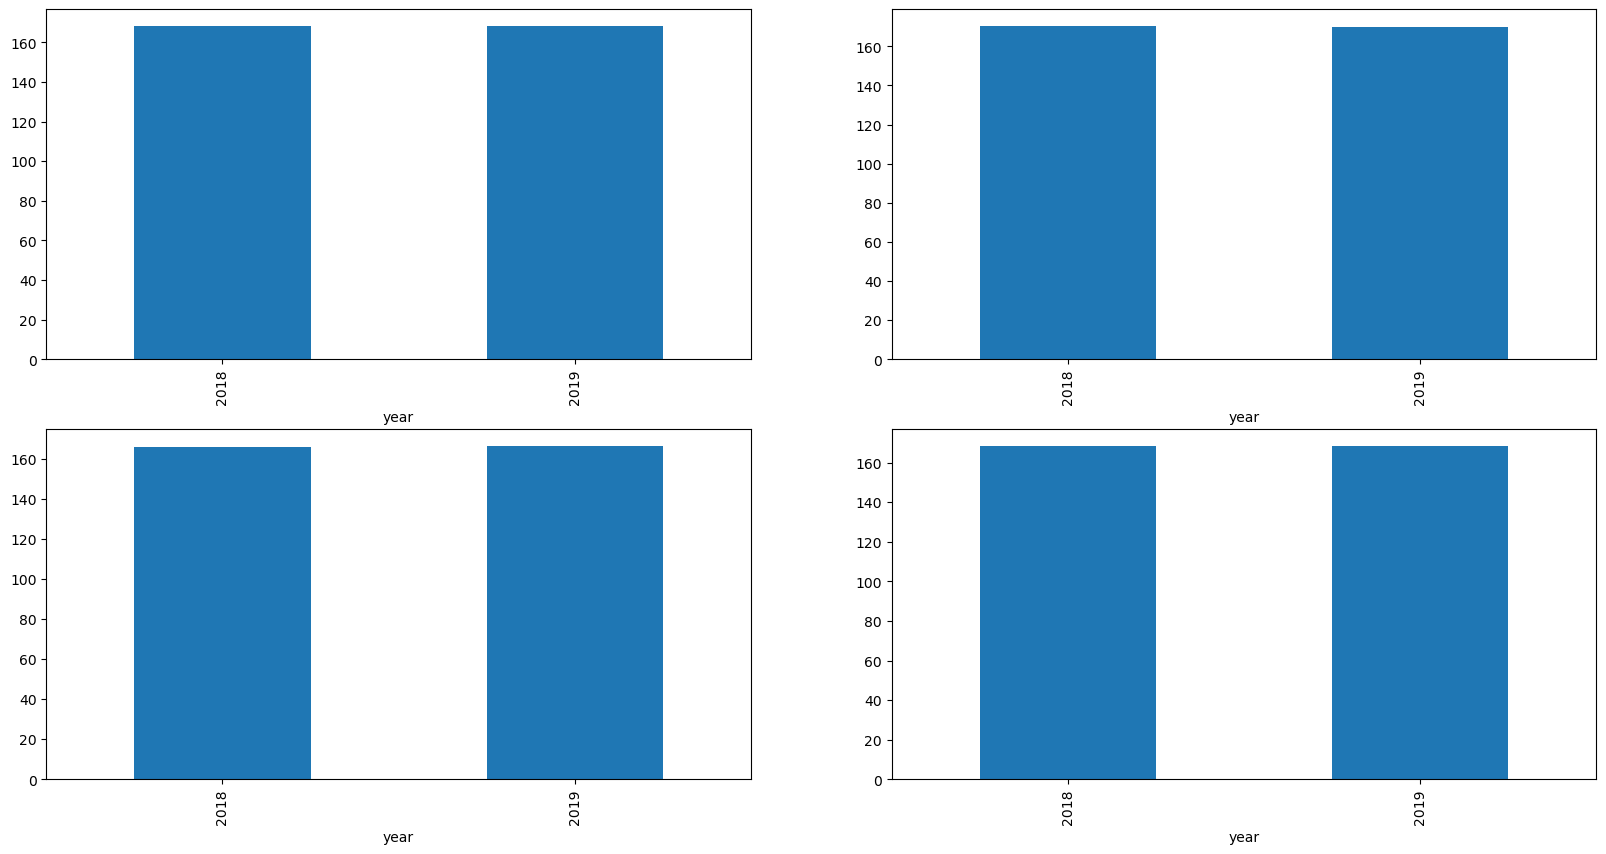

In [24]:
data_grouped = df.groupby('year').mean() 
plt.subplots(figsize=(20,10)) 
  
for i, col in enumerate(['Open', 'High', 'Low', 'Close']): 
  plt.subplot(2,2,i+1) 
  data_grouped[col].plot.bar() 
plt.show()

In [26]:
df.groupby('year').mean()

,Open,High,Low,Close,Volume,day,month,is_quarter_end
year,,,,,,,,
2018,168.306994,170.473987,166.211503,168.333921,2.538332e+07,16.503268,8.803922,0.385621
2019,168.049596,170.137171,166.529394,168.462323,1.842648e+07,14.929293,2.939394,0.212121


In [27]:
df['open-close']  = df['Open'] - df['Close'] 
df['low-high']  = df['Low'] - df['High'] 
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

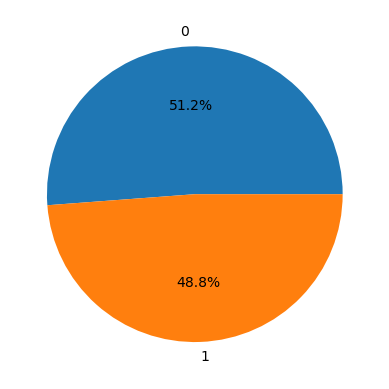

In [29]:
plt.pie(df['target'].value_counts().values, labels=[0, 1], autopct='%1.1f%%') 
plt.show()

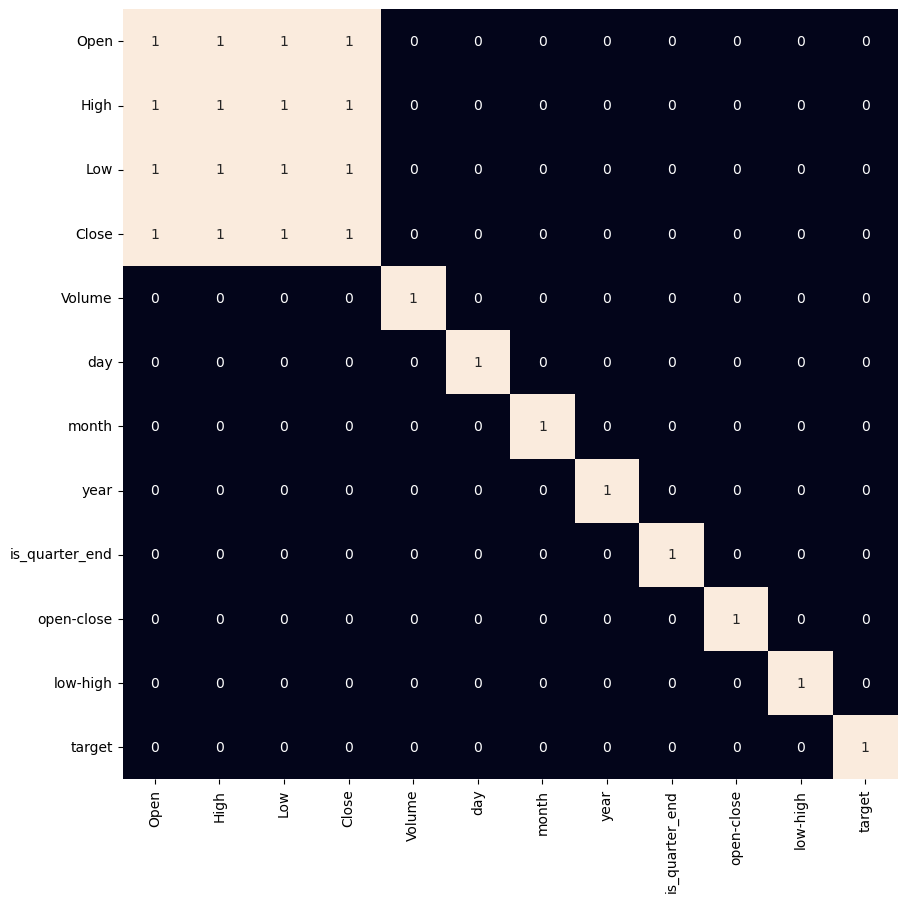

In [31]:
plt.figure(figsize=(10, 10)) 
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False) 
plt.show() 
#there is a high correlation between OHLC

In [34]:
#data splitting and normalization
features = df[['open-close', 'low-high', 'year']] 
target = df['target'] 

scaler = StandardScaler() 
features = scaler.fit_transform(features) 

X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.1, random_state=2022) 
print(X_train.shape, X_valid.shape) 


(226, 3) (26, 3)


In [36]:
#Model Development and Evaluation
models = [LogisticRegression(), SVC( 
kernel='poly', probability=True), XGBClassifier()] 

for i in range(3): 
    models[i].fit(X_train, Y_train) 

print(f'{models[i]} : ') 
print('Training Accuracy : ', metrics.roc_auc_score( 
	Y_train, models[i].predict_proba(X_train)[:,1])) 
print('Validation Accuracy : ', metrics.roc_auc_score( 
	Y_valid, models[i].predict_proba(X_valid)[:,1])) 
print()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9992554858934168
Validation Accuracy :  0.3846153846153846



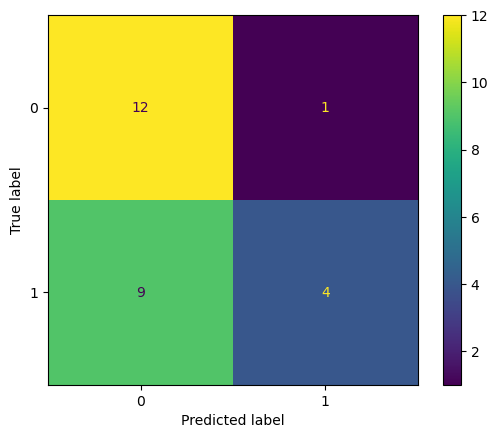

In [37]:
metrics.plot_confusion_matrix(models[0], X_valid, Y_valid) 
plt.show()
